# Flux with MNIST


## Libraries

In [1]:
#using CUDA

using Flux              # the julia ml library
using Images            # image processing and machine vision for julia

using MLJ               # make_blobs, rmse, confmat, f1score, coerce
#using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq, stratifiedobs
using MLDatasets        # mnist

using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Dataset

,,,,

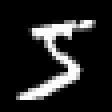
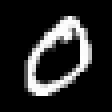
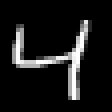
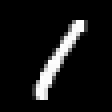
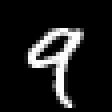

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [3]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [4]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X, y = preprocess(trainX, trainY);

In [6]:
d, N, size(X), size(y)

(784, 42001, (784, 42001), (10, 42001))

### Built-in Sigmoid

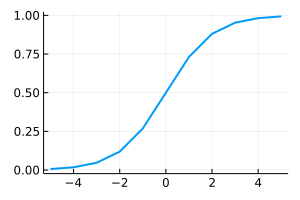

In [7]:
# built-in sigmoid function "\sigma<tab>"
plot(-5:5, σ.(-5:5), size=(300,200), linewidth=2, legend=false)
#plot(-5:5, relu.(-5:5), size=(300,200), linewidth=2, legend=false)

### Model

In [8]:
# model configuration
nInputs  = d
nOutputs = 10
model = Flux.Dense(nInputs, nOutputs, relu)
#model = Chain( Flux.Dense(nInputs, nOutputs, identity), softmax)

losses(X, y)    = Flux.crossentropy( model(X), y )
modelParameters = Flux.params(model)
dataLoader      = Flux.DataLoader((X, y), batchsize=512)           # default batchsize=1
callBack        = Flux.throttle(() -> println("training"), 10);    # print every 10s


### Train

In [9]:
# Flux.train!(loss, params, data, opt; cb)
@time Flux.train!(losses, modelParameters, dataLoader, Descent())   # single epoch
@time Flux.train!(losses, modelParameters, dataLoader, Descent())   # single epoch

# cpu time (batchsize=1): 2-3s

 27.768466 seconds (50.05 M allocations: 3.171 GiB, 3.09% gc time, 98.74% compilation time)
  0.249216 seconds (16.59 k allocations: 270.696 MiB, 15.68% gc time)


In [10]:
# preferred for multiple epochs
epochs = 10
@time for i in 1:epochs Flux.train!(losses, modelParameters, dataLoader, Descent(); cb=callBack) end

training
  2.241246 seconds (471.26 k allocations: 2.660 GiB, 4.13% gc time, 13.23% compilation time)


### Predict

In [11]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end


predictOutcome (generic function with 1 method)

,,,,,,,

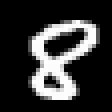
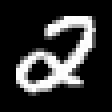
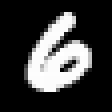
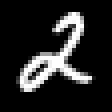
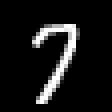
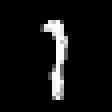
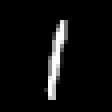
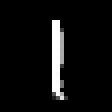

1×8 adjoint(::Vector{Int64}) with eltype Int64:
 8  2  6  2  7  1  1  1

In [12]:
ŷ = predictOutcome(X)

display([MNIST.convert2image(trainX[:,:,i]) for i in 1:8])
ŷ[1:8]'

In [13]:
printMetrics( coerce(ŷ, OrderedFactor), coerce(trainY, OrderedFactor) )

10×10 Matrix{Int64}:
 3814     0   100    49    21   156   103    71    40    60
    0  4579   353   114   112   272   116   263   461   153
   29    34  3112   113    28    55   133    55    82    40
   68    25   164  3665     5  1041    21     9   551    89
    8     2    81     7  3020    94    34    49    33   271
   70    13     4    27     0  1710    63     1    65     8
  106     7   130    36    66    97  3652     4    38     5
    4     6    91    69    31    58     1  3764    46   327
   33    43   115   116    42    84    19    21  2569    43
   14    10    21    96   764   228     1   149   211  3168

accuracy: 0.787
f1-score: 0.78
